
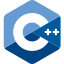
<br>

<div style="text-align:center; font-size:200%;">
  <b>The Curiously Recurring Template Pattern (CRTP)</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Academy Munich</div>
<br/>
<!-- 11 The Curiously Recurring Template Pattern (CRTP).ipynb -->
<!-- slides/module_470_cpp_patterns/topic_210_crtp.cpp -->

<!--
clang-format on
-->


- The CRTP is an idiom that allows "static inheritance" of behavior
- The base class is a template class that is specialized by the derived class


### Intent of the Template Method Pattern

Define a behavior or an algorithm, in which subclasses can implement or
modify certain steps. The subclasses can override individual steps of the
algorithm, but have no influence on its overall structure.


### Motivation for the Template Method Pattern

- An application that has to deal with different types of documents
- Common functionality implemented in a base class
- Subclasses specialize individual steps


## Class Diagram

<img src="img/template_method_example.svg"
     style="display:block;margin:auto;width:40%"/>

In [ ]:
#include <iostream>
#include <string>

In [ ]:
class Document {
public:
    virtual ~Document() = default;

    void Save() {
        std::cout << "Saving to existing file.\n";
        DoSave();
        std::cout << "Document saved.\n\n";
    }

    void SaveAs() {
        std::cout << "Asking user for file name.\n";
        DoSave();
        std::cout << "Document saved.\n\n";
    }

protected:
    virtual void DoSave() = 0;
};

In [ ]:
class TextDocument : public Document {
    void DoSave() override { std::cout << "-> Saving text document in DOCX format.\n"; }
};

In [ ]:
class SpreadsheetDocument : public Document {
    void DoSave() override { std::cout << "-> Saving spreadsheet in XLSX format.\n"; }
};

In [ ]:
SpreadsheetDocument spreadsheet;
spreadsheet.Save();
spreadsheet.SaveAs();

In [ ]:
TextDocument text;
text.Save();
text.SaveAs();


### Structure of the Template Method Pattern

<img src="img/pat_template_method.svg"
     style="display:block;margin:auto;width:40%"/>


## Implementation with Templates

In [ ]:
template <typename T>
class DocumentV1 {
public:
    void Save() {
        std::cout << "Saving to existing file.\n";
        T::DoSave();
        std::cout << "Document saved.\n\n";
    }

    void SaveAs() {
        std::cout << "Asking user for file name.\n";
        T::DoSave();
        std::cout << "Document saved.\n\n";
    }
};

In [ ]:
class TextDocumentV1 {
public:
    static void DoSave() { std::cout << "-> Saving text document in DOCX format.\n"; }
};

In [ ]:
class SpreadsheetDocumentV1 {
public:
    static void DoSave() { std::cout << "-> Saving spreadsheet in XLSX format.\n"; }
};


- Specialized functions must be static and have no access to object data
- We cannot work with `TextDocumentV1` and `SpreadsheetDocumentV1` without
  wrapping them in a `DocumentV1` object

In [ ]:
DocumentV1<TextDocumentV1> textV1;
textV1.Save();

In [ ]:
DocumentV1<SpreadsheetDocumentV1> spreadsheetV1;
spreadsheetV1.Save();


# Implementation using CRTP

- "Base" class `Base` gets "derived" class `Derived` as a template parameter
- `Base` uses a `static_cast` to convert the `this` pointer to a pointer to
  `Derived`
- `Derived` inherits from `Base<Derived>`
- We achieve the same effect as with the Template Method Pattern, but save a
  virtual dispatch

In [ ]:
template <typename Derived>
class DocumentV2 {
public:
    void Save() {
        std::cout << "Saving to existing file.\n";
        static_cast<Derived*>(this)->DoSave();
        std::cout << "Document saved.\n\n";
    }

    void SaveAs() {
        std::cout << "Asking user for file name.\n";
        static_cast<Derived*>(this)->DoSave();
        std::cout << "Document saved.\n\n";
    }
};

In [ ]:
class TextDocumentV2 : public DocumentV2<TextDocumentV2> {
public:
    void DoSave() { std::cout << "-> Saving text document in DOCX format.\n"; }
};

In [ ]:
class SpreadsheetDocumentV2 : public DocumentV2<SpreadsheetDocumentV2> {
public:
    void DoSave() { std::cout << "-> Saving spreadsheet in XLSX format.\n"; }
};


- Now we can work directly with `TextDocumentV2` and `SpreadsheetDocumentV2`
- `DoSave` is a normal member function that can access object data

In [ ]:
TextDocumentV2 textV2;
textV2.Save();

In [ ]:
SpreadsheetDocumentV2 spreadsheetV2;
spreadsheetV2.Save();


## CRTP in the standard library

- `std::enable_shared_from_this`
- `ranges::view_interface`


## Advantages of CRTP

- No virtual dispatch
- No polymorphic containers possible
- No dynamic exchange of implementations possible


## C++ 23

Instead of

```cpp
template <class Derived>
struct Base { void Fun() { (static_cast<Derived*>(this))->Impl(); } };
```

the base class can be defined with an explicit `this` parameter:

```cpp
struct Base { void Fun(this auto&& self) { self.Impl(); } };
```